<center>
<div class="alert alert-block alert-info">
<h1>Data Modeling</h1>
    </div>

<a id=menu></a>
## Menu

* [Imports](#imports)
* [Add Customers with Unknown ID](#add_nans)
* [Linear Regression](#linear_reg)
    * [Linear Regression Hyperparameter Tuning](#lrhypertune)
* [KNearest Neighbor](#knn)
* [RandomForestRegressor](#rf)
* [ARIMA](#arima)
    - [Dicky Fuller Test](#dicky_fuller)
    - [Optimize ARIMA Model](#optimize_model)
* [Summary](#summary)


<a id=imports></a>
## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from datetime import datetime
import os

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima_model import  ARIMA
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = '../cleaned_data'
file_path = '/clean_sales_df.csv'

In [3]:
os.listdir(data_path)

['rfm_data.csv',
 '.DS_Store',
 'clean_sales_df.csv',
 'data_with_all_customer_ids.csv',
 'kmeans_4_groups.csv',
 'data_with_all_customers.csv',
 'rfm_data.pkl',
 'hierchichal_4_groups.csv',
 'nan_customers.csv']

In [4]:
#import data
data = pd.read_csv(data_path+file_path, index_col = 0,parse_dates = ['InvoiceDate'])
data.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Revenue,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12-01 00:00:00,83.4,2009,12,1,4,49,1,335
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01 00:00:00,81.0,2009,12,1,4,49,1,335


In [5]:
data.shape

(770386, 17)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 770386 entries, 0 to 1067369
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      770386 non-null  int64         
 1   StockCode    770386 non-null  object        
 2   Description  770386 non-null  object        
 3   Quantity     770386 non-null  int64         
 4   InvoiceDate  770386 non-null  datetime64[ns]
 5   Price        770386 non-null  float64       
 6   Customer ID  770386 non-null  float64       
 7   Country      770386 non-null  object        
 8   Date         770386 non-null  object        
 9   Revenue      770386 non-null  float64       
 10  Year         770386 non-null  int64         
 11  Month        770386 non-null  int64         
 12  Day          770386 non-null  int64         
 13  Quarter      770386 non-null  int64         
 14  Week         770386 non-null  int64         
 15  Week_day     770386 non-null  int

<a id=add_nans></a>
### Add Customers with No ID

>Import the dataframe with guest customers, who have no ID and add it to my dataframe, because all I care about are the sales 

In [5]:
#load data for unknown customers
nan_customers = pd.read_csv(data_path + '/nan_customers.csv',index_col=0,parse_dates = ['InvoiceDate'])
nan_customers.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Revenue,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom,2009-12-01 00:00:00,0.55,2009,12,1,4,49,1,335
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom,2009-12-01 00:00:00,0.85,2009,12,1,4,49,1,335
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom,2009-12-01 00:00:00,2.95,2009,12,1,4,49,1,335
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom,2009-12-01 00:00:00,15.00,2009,12,1,4,49,1,335
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom,2009-12-01 00:00:00,8.85,2009,12,1,4,49,1,335


In [6]:
#making sure customer id is all nans
nan_customers.shape[0], nan_customers['Customer ID'].isna().sum()

(226860, 226860)

In [7]:
#lets see how much sales do the guest customers account for
print('Guest customers account for: {}% of all sales'.format((nan_customers.Revenue.sum()/data.Revenue.sum() *100).round(2)))

Guest customers account for: 15.61% of all sales


In [8]:
#merge data and nan_customers dataframes
df = pd.concat([data, nan_customers],axis=0)
print(df.shape)
df.head(2)

(997246, 17)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Revenue,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12-01 00:00:00,83.4,2009,12,1,4,49,1,335
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01 00:00:00,81.0,2009,12,1,4,49,1,335


In [9]:
#rename revenue to sales for ease of use
df.rename(columns={'Revenue':'Sales'},inplace=True)
df.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Sales,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12-01 00:00:00,83.4,2009,12,1,4,49,1,335
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01 00:00:00,81.0,2009,12,1,4,49,1,335


In [11]:
#see if there are sales that are 0 and delete them becuase these are not sales
print(df.Sales.shape)
df = df[df.Sales!=0]
print(df.Sales.shape)

(997246,)
(997246,)


In [13]:
#save df with all customers
df.to_csv('../cleaned_data/data_with_all_customer_ids.csv')

In [10]:
#drop products with no description
df = df[df['Description'].notna()]
#any weird description
(pd.Series(df['Description'].unique()).apply(lambda x: len(x))<2).sum()

0

### Investigate Sales

One of the most important tasks for any retail store company is to analyze the performance of its stores. The main challenge faced by any retail store is predicting in advance the sales and inventory required at each store to avoid over-stocking and under-stocking. This helps the business to provide the best customer experience and avoid getting into losses, thus ensuring the store is sustainable for operation.

Date’ is one of the important factors influencing sales and it acts as an independent variable. To put it simply, this is a time-series data i.e a series of data points ordered in time.

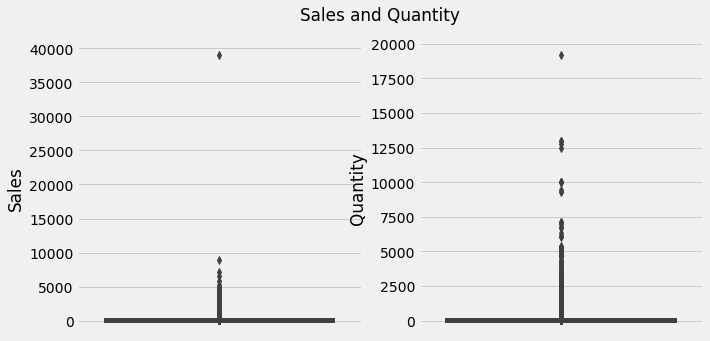

In [17]:
#display sales, the target variable, boxplot
f,ax = plt.subplots(1,2,figsize=(10,5))
sns.boxplot(y=df.Sales,ax=ax[0])
sns.boxplot(y=df.Quantity,ax=ax[1])
f.suptitle('Sales and Quantity');


In [11]:
#The top 10 most lucrative products
imp_prod = df.groupby('StockCode')['Sales'].sum().sort_values(ascending=False).reset_index()[:10]
imp_prod

,StockCode,Sales
0,22423,321761.92
1,85123A,249074.21
2,85099B,179049.21
3,47566,147460.58
4,84879,128653.51
5,22086,116666.54
6,79321,80082.58
7,22197,79344.75
8,22386,75542.07
9,20725,70280.64


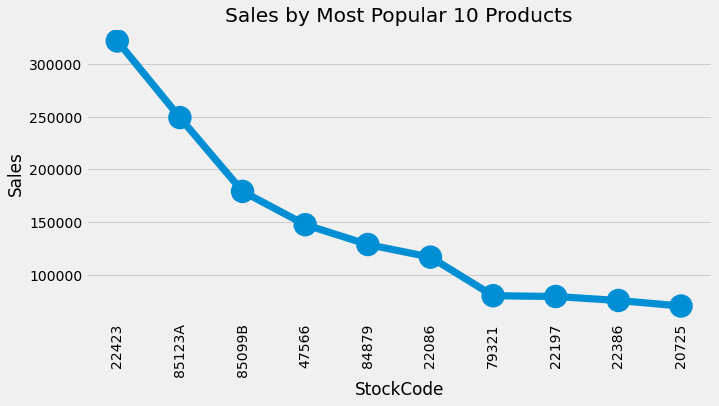

In [13]:
#plot the 10 most lurative products
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,5))
sns.pointplot( x='StockCode',y='Sales',data=imp_prod)
plt.xticks(rotation=90)
plt.title('Sales by Most Popular 10 Products')
plt.show()

>Look at sales by quarter, month, day, year

In [13]:
#create a dataframe for monthly total sales by year and moth
sales_monthly = df.groupby(['Year','Month'])['Sales'].sum().reset_index()


In [14]:
#create a dataframe of sum monthly dollar sales 
month_dict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

sales_monthly = df.groupby(['Year','Month'])['Sales'].sum().reset_index()
sales_monthly['Monthly'] = pd.to_datetime(sales_monthly[['Year','Month']].assign(DAY=1))
sales_monthly['Month_name'] = sales_monthly.Month.map(month_dict)

#create a dataframe of average monthly dollar sales 
sales_monthly_avg = df.groupby(['Year','Month'])['Sales'].mean().reset_index()
sales_monthly_avg['Monthly'] = pd.to_datetime(sales_monthly[['Year','Month']].assign(DAY=1))
sales_monthly_avg['Month_name'] = sales_monthly.Month.map(month_dict)

#create a dataframe of sum monthly quantity 
quantity_monthly_sum = df.groupby(['Year','Month'])['Sales'].sum().reset_index()
quantity_monthly_sum['Monthly'] = pd.to_datetime(sales_monthly[['Year','Month']].assign(DAY=1))
quantity_monthly_sum['Month_name'] = sales_monthly.Month.map(month_dict)


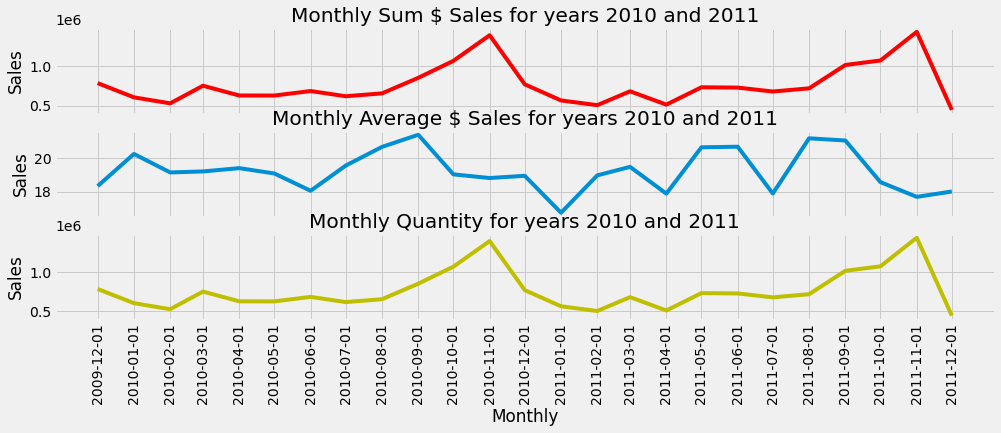

In [19]:
#plot monthly sales trend
x_ticks = sales_monthly_avg['Monthly'].dt.date
f,ax = plt.subplots(3,1,figsize=(15,5),sharex=True)

sns.lineplot(data=sales_monthly,x='Monthly',y='Sales',ax=ax[0],color='red')
ax[0].set_title('Monthly Sum $ Sales for years 2010 and 2011')

sns.lineplot(data=sales_monthly_avg,x='Monthly',y='Sales',ax=ax[1])
ax[1].set_title('Monthly Average $ Sales for years 2010 and 2011')

sns.lineplot(data=quantity_monthly_sum,x='Monthly',y='Sales',ax=ax[2],color='y')
ax[2].set_title('Monthly Quantity for years 2010 and 2011')

plt.xticks(x_ticks,rotation=90);

- In September 2010 there is a spike in average sales which then goes down but in sum of sales continues to rise, which means that the number of orders continues to increase of products of similar value. 

- In November there is a spike in sum of sales, which is probably the Christmas rush which starts slowing down in December, meaning that most people buy their gifts in November. Since this is an online store it makes sense that people would order gifts early so that they arrive on time. It is interesting to note that in November sum of sales goes up while average sales goes down, which means that there are many small orders. 



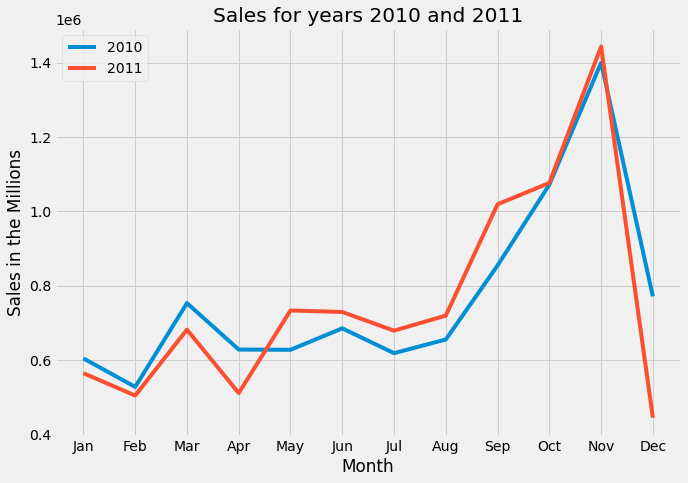

In [20]:
#plot sales for years 2010 and 2011
#plt.subplots(1,2,figsize=(7,7))
#sns.lineplot(data=sales_monthly,x='Monthly',y='Sales')
#plt.title('Sales for years 2010 and 2011')
plt.figure(figsize=(10,7))
sns.lineplot(data=sales_monthly[sales_monthly.Year==2010],x='Month_name',y='Sales',label=2010)
sns.lineplot(data=sales_monthly[sales_monthly.Year==2011],x='Month_name',y='Sales',label=2011)
plt.xlabel('Month')
plt.ylabel('Sales in the Millions')
plt.title('Sales for years 2010 and 2011');

>Both years follow the same sales trend with a noticeable increase in sales starting in August until November  for Christmas in both years, and this might affect our predictions, so I might separate the sales data into sales before Christmas and sale after. 

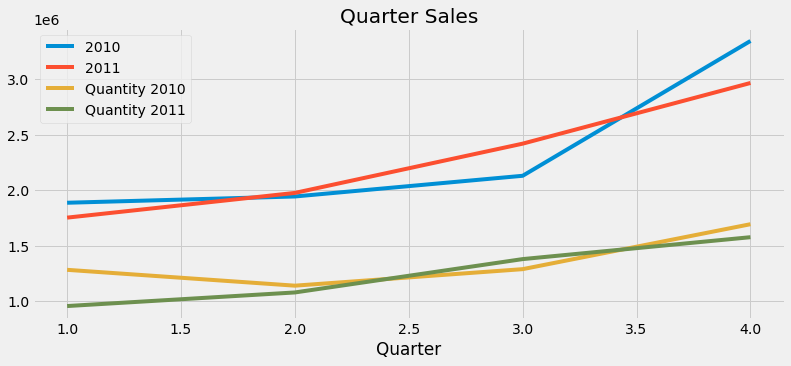

In [575]:
#plot quarterly 
plt.figure(figsize=(12,5))
df[df.Year==2010].groupby('Quarter')['Sales'].sum().plot(label=2010)
df[df.Year==2011].groupby('Quarter')['Sales'].sum().plot(label=2011)
df[df.Year==2010].groupby('Quarter')['Quantity'].sum().plot(label='Quantity 2010')
df[df.Year==2011].groupby('Quarter')['Quantity'].sum().plot(label='Quantity 2011')

plt.legend()
plt.title('Quarter Sales');

>There is an increase at last quarter because of the increased sales for Christmas

In [794]:
#look at daily sum of sales
day_dict = {0:'Mon',1:'Tue',2:'Wed',3:'Thr',4:'Fri',5:'Sat',6:'Sun'}
daily_sum = df.groupby('Week_day')['Sales'].sum().reset_index()
daily_avg = df.groupby('Week_day')['Sales'].mean().reset_index()

daily_sum['Week_day']=daily_sum.Week_day.map(day_dict)
daily_avg['Week_day']=daily_avg.Week_day.map(day_dict)
daily_sum 

,Week_day,Sales
0,Mon,3.422346e+06
1,Tue,3.835666e+06
2,Wed,3.454463e+06
3,Thr,4.030999e+06
4,Fri,2.995188e+06
5,Sat,9.518430e+03
6,Sun,1.810949e+06


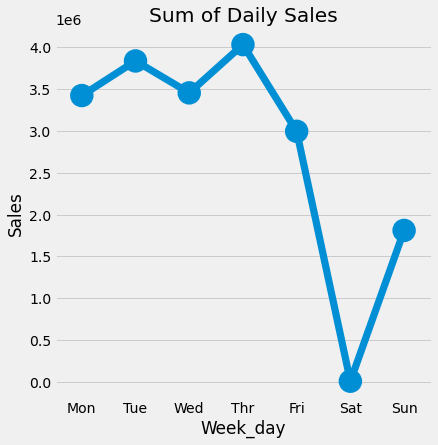

In [795]:
#plot daily sum of sales
sns.factorplot(data=daily_sum,x='Week_day',y='Sales',size=6, aspect=1)

plt.title('Sum of Daily Sales');

>Sales seem to decrease on Saturday, which makes sense since this data is for an online store people would go out on Saturday and make their orders on Sunday.

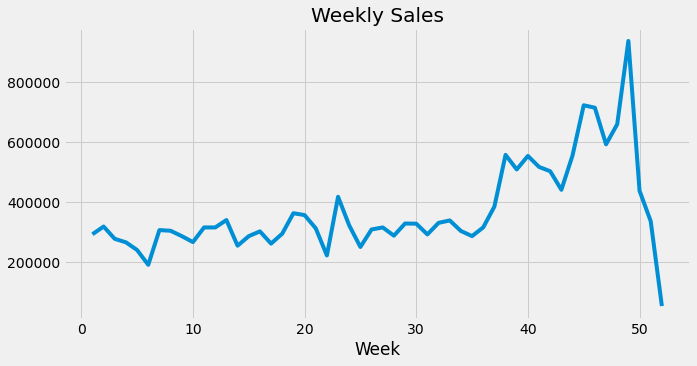

In [576]:
#look at weekly sum of sales
plt.figure(figsize=(10,5))

df.groupby('Week')['Sales'].sum().plot()
plt.title('Weekly Sales');

>Again sales increase by end of year

Text(0.5, 1.0, 'Sum Sales per Year')

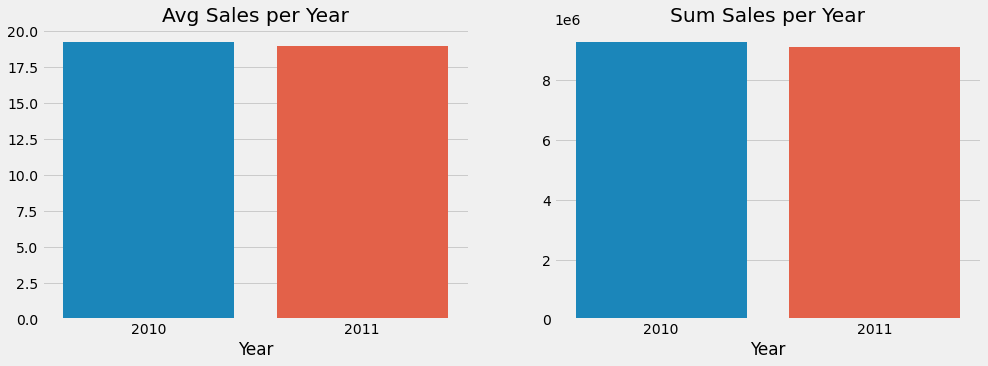

In [577]:
#look at average sales for year 2009 and 2010
yearly_avg = df[df.Year>2009].groupby('Year')['Sales'].mean()
yearly_sum = df[df.Year>2009].groupby('Year')['Sales'].sum()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(x=yearly_avg.index, y=yearly_avg.values)
plt.title('Avg Sales per Year')
plt.subplot(1,2,2)

sns.barplot(x=yearly_sum.index, y=yearly_sum.values)
plt.title('Sum Sales per Year')


>There is a slight decrease in average and sum of sales from 2010 to 2011, which could mean that there is less orders being made

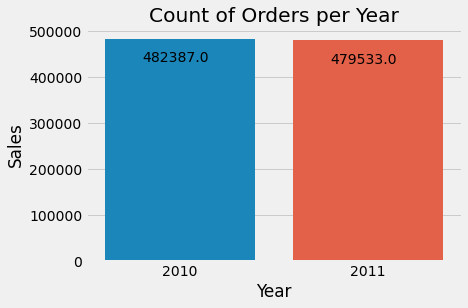

In [578]:
#investigate the number of orders per year
yearly_count = df[df.Year>2009].groupby('Year')['Sales'].count().reset_index()
#yearly_sum = data[data.Year>2009].groupby('Year')['Sales'].sum()
p = sns.barplot(x=yearly_count.Year, y=yearly_count.Sales)
for bar in p.patches:
    p.annotate(bar.get_height(),  xy = (bar.get_x()+0.2,bar.get_height()-50000))

plt.title('Count of Orders per Year');


>the number of orders made has gone down but only slightly

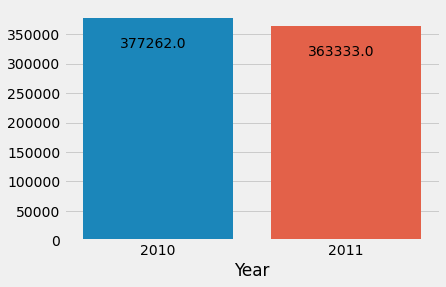

In [579]:
#Investigare number of customers per year
yearly_customers = df[df.Year>2009].groupby('Year')['Customer ID'].count()
p=sns.barplot(x=yearly_customers.index, y=yearly_customers.values)

for bar in p.patches:
    p.annotate(bar.get_height(),  xy = (bar.get_x()+0.2,bar.get_height()-50000))

>also the number of customers has gone down slightly

>In order to use time series forecasting models, we need to ensure that our time series data is stationary i.e constant mean, constant variance and constant covariance with time.

>so to check if time series is stationary there are tow tests, the rolling mean and the Dicky Fuller Test

[Back to Menu](#menu)

<a id='response_variable'></a>
### Response Variable

In [12]:
#look at distibution of sales and qunatity
df.loc[:,['Sales','Quantity']].describe().apply(lambda x: x.apply(lambda x: format(x,'f')))

,Sales,Quantity
count,997246.000000,997246.000000
mean,19.148402,10.819288
std,73.039130,64.065291
min,0.001000,1.000000
25%,4.130000,1.000000
50%,10.000000,4.000000
75%,17.700000,12.000000
max,38970.000000,19152.000000


Looking at the min and max values there is a great variation in sales and quantity,

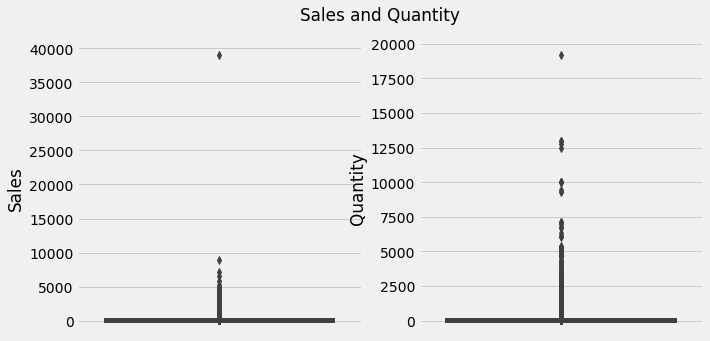

In [22]:
#display sales, the target variable, boxplot
f,ax = plt.subplots(1,2,figsize=(10,5))
sns.boxplot(y=df.Sales,ax=ax[0])
sns.boxplot(y=df.Quantity,ax=ax[1])
f.suptitle('Sales and Quantity');

In [768]:
#explore that big outlier above 35000
df[df.Sales>35000]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Sales,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
748132,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098.0,United Kingdom,2011-06-10 00:00:00,38970.0,2011,6,10,2,23,4,161


In [769]:
#explore price range of this product
df[df.Description.str.contains('PICNIC BASKET WICKER')]['Price'].unique()


array([  8.5 ,   9.95,   4.25,   3.75,   5.95,   4.95,   7.62,   3.  ,
       649.5 ,   2.  ,  21.23,   8.47,   8.29,  20.79,  10.79,   8.95])

In [770]:
#are there any product for that price of 649.5
df[df.Price==649.5]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Sales,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
748132,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098.0,United Kingdom,2011-06-10 00:00:00,38970.0,2011,6,10,2,23,4,161
748143,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.5,15098.0,United Kingdom,2011-06-10 00:00:00,649.5,2011,6,10,2,23,4,161


In [772]:
#these two entries do not make sense one with quantity of 60 and the other with quantity 1 for the same price, I think 
#these should be deleted
df = df[df.Price!=649.5]


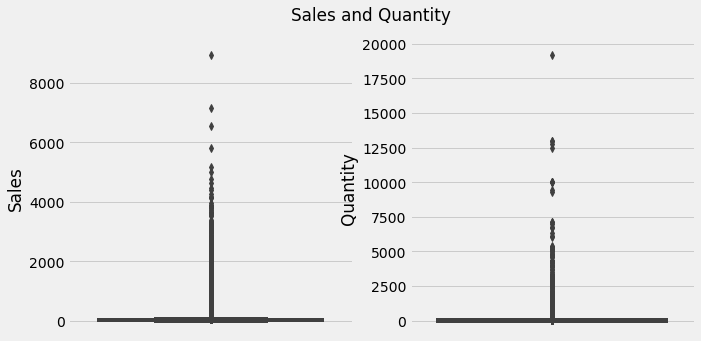

In [773]:
f,ax = plt.subplots(1,2,figsize=(10,5))
sns.boxplot(y=df.Sales[df.Sales<35000],ax=ax[0])
sns.boxplot(y=df.Quantity,ax=ax[1])
f.suptitle('Sales and Quantity');

>The target variables shows extreme outliers, I need to investigate the reason for them. 

In [776]:
#find the interquartile range (IQR)
q1 = np.quantile(df.Sales,.25)
q3 = np.quantile(df.Sales,.75)
iqr = q3-q1
lower_limit = q1-1.5*iqr
upper_limit = q3+1.5*iqr

q1_q = np.quantile(df.Quantity,.25)
q3_q = np.quantile(df.Quantity,.75)
iqr_q = q3_q - q1_q
lower_limit_q = q1_q-1.5*iqr_q
upper_limit_q = q3_q+1.5*iqr_q
upper_limit,df.Sales.quantile(0.01),df.Sales.quantile(0.99),df.Quantity.quantile(0.01),df.Quantity.quantile(0.99)

(38.400000000000006, 0.65, 178.34299999999115, 1.0, 100.0)

In [777]:
df[df.Sales>178]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Sales,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
67,489438,85132A,CHARLIE + LOLA BISCUITS TINS,60,2009-12-01 09:24:00,6.38,18102.0,United Kingdom,2009-12-01 00:00:00,382.80,2009,12,1,4,49,1,335
68,489438,85132C,CHARLIE AND LOLA FIGURES TINS,60,2009-12-01 09:24:00,6.40,18102.0,United Kingdom,2009-12-01 00:00:00,384.00,2009,12,1,4,49,1,335
95,489441,22111,SCOTTIE DOG HOT WATER BOTTLE,48,2009-12-01 09:44:00,4.25,18087.0,United Kingdom,2009-12-01 00:00:00,204.00,2009,12,1,4,49,1,335
176,489448,20823,GOLD WINE GOBLET,48,2009-12-01 10:18:00,4.25,15413.0,United Kingdom,2009-12-01 00:00:00,204.00,2009,12,1,4,49,1,335
282,489465,84879,ASSORTED COLOUR BIRD ORNAMENT,160,2009-12-01 10:52:00,1.45,13767.0,United Kingdom,2009-12-01 00:00:00,232.00,2009,12,1,4,49,1,335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066747,581497,22355,CHARLOTTE BAG SUKI DESIGN,110,2011-12-09 10:23:00,2.46,NaN,United Kingdom,2011-12-09 00:00:00,270.60,2011,12,9,4,49,4,343
1066751,581497,22423,REGENCY CAKESTAND 3 TIER,8,2011-12-09 10:23:00,24.96,NaN,United Kingdom,2011-12-09 00:00:00,199.68,2011,12,9,4,49,4,343
1066765,581497,23084,RABBIT NIGHT LIGHT,37,2011-12-09 10:23:00,4.96,NaN,United Kingdom,2011-12-09 00:00:00,183.52,2011,12,9,4,49,4,343
1066774,581497,23355,HOT WATER BOTTLE KEEP CALM,36,2011-12-09 10:23:00,8.29,NaN,United Kingdom,2011-12-09 00:00:00,298.44,2011,12,9,4,49,4,343


In [627]:
#how many outliers are there in sales, see if these are orders during christmas period
pd.to_datetime(df.InvoiceDate[df.Sales>upper_limit]).dt.month.value_counts().sort_values(ascending=False),\
pd.to_datetime(df.InvoiceDate[df.Quantity>upper_limit_q]).dt.month.value_counts().sort_values(ascending=False),\



(11    11839
 12     9390
 10     8848
 9      7949
 5      6111
 3      6110
 8      5969
 6      5835
 7      5307
 4      4979
 1      4795
 2      4499
 Name: InvoiceDate, dtype: int64,
 11    7157
 10    5873
 9     5297
 12    5155
 8     4207
 5     3955
 6     3938
 3     3910
 7     3766
 4     3340
 1     2968
 2     2752
 Name: InvoiceDate, dtype: int64)

>The largest orders are happening between months 9 to 12 which is pre_christmas time

(array([34.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([ 272.27 ,  360.758,  449.246,  537.734,  626.222,  714.71 ,
         803.198,  891.686,  980.174, 1068.662, 1157.15 ]),
 <BarContainer object of 10 artists>)

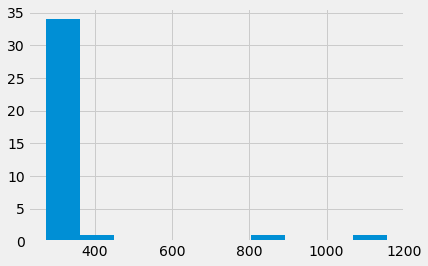

In [713]:
#I want to explore price because it seems that there are mistakes there and I think there is a problem here
#sns.boxplot(df.Price)
plt.hist(df.Price[df.Price>200])

In [721]:
#there appears to be some items with high prices
df[df.Price>300]


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date,Sales,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
249672,513564,ADJUST2,Adjustment by Peter on Jun 25 2010,1,2010-06-25 14:15:00,300.13,17050.0,United Kingdom,2010-06-25 00:00:00,300.13,2010,6,25,2,25,4,176
249673,513566,ADJUST2,Adjustment by Peter on Jun 25 2010,1,2010-06-25 14:15:00,358.47,17364.0,United Kingdom,2010-06-25 00:00:00,358.47,2010,6,25,2,25,4,176
136403,502451,84016,FLAG OF ST GEORGE CAR FLAG,1,2010-03-24 14:14:00,867.79,NaN,United Kingdom,2010-03-24 00:00:00,867.79,2010,3,24,1,12,2,83
180997,506571,84016,FLAG OF ST GEORGE CAR FLAG,1,2010-04-30 13:04:00,408.40,NaN,United Kingdom,2010-04-30 00:00:00,408.40,2010,4,30,2,17,4,120
192196,507637,84016,FLAG OF ST GEORGE CAR FLAG,1,2010-05-10 14:55:00,1157.15,NaN,United Kingdom,2010-05-10 00:00:00,1157.15,2010,5,10,2,19,0,130


In [716]:

q1_p = np.quantile(df.Price,.25)
q3_p = np.quantile(df.Price,.75)
iqr_p = q3_p - q1_p

upper_limit_p = q3_p+1.5*iqr
df.Price.quantile(0.90),upper_limit


(7.62, 38.05500000000001)

In [ ]:
df

<AxesSubplot:xlabel='Quantity', ylabel='Density'>

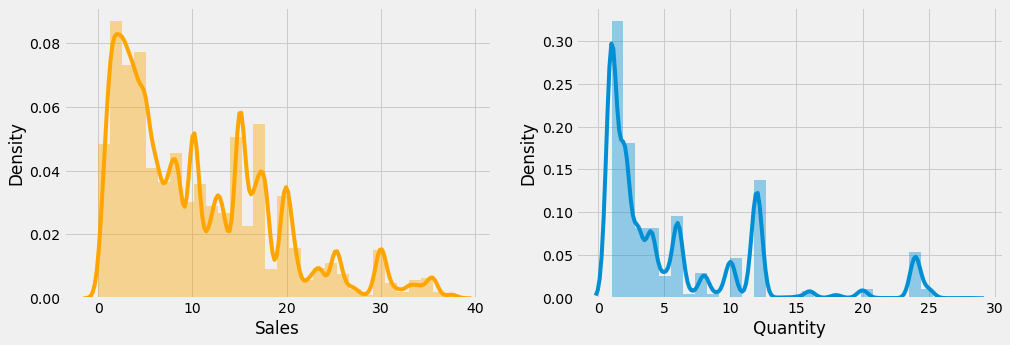

In [644]:
#plot values below the limits just to be able to see the distribution, if I use all values the outliers won't 
#enable me to see the distribution
f,ax = plt.subplots(1,2,figsize=(15,5))
sns.distplot(df.Sales[df.Sales<=upper_limit],kde=True,ax=ax[0],bins=30,color='orange')
sns.distplot(df.Quantity[df.Quantity<=upper_limit_q],kde=True,ax=ax[1],bins=30)

>most sales are on the lower end between 0 and 10, as for quantity, most orders are low quantities 

<AxesSubplot:xlabel='Quantity', ylabel='Density'>

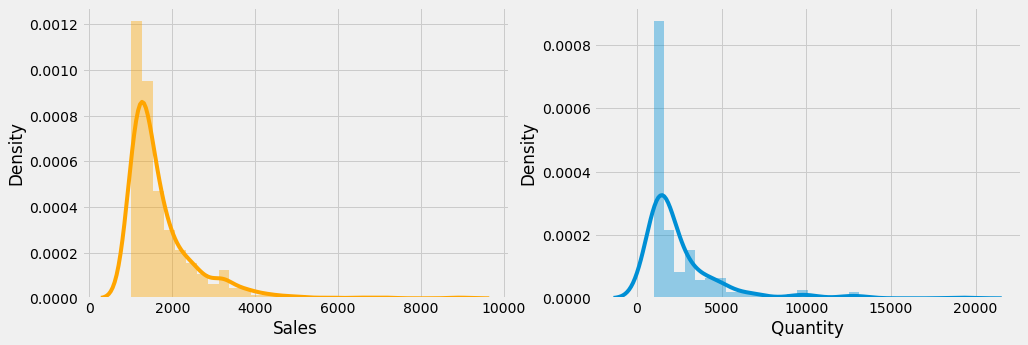

In [682]:
f,ax = plt.subplots(1,2,figsize=(15,5))
sns.distplot(df.Sales[(df.Sales>1000) & (df.Sales<35000)],kde=True,ax=ax[0],bins=30,color='orange')
sns.distplot(df.Quantity[df.Quantity>1000],kde=True,ax=ax[1],bins=30)

<a id='linear_reg'></a>
### Linear Regression

> Metrics used:
- Rsquared: measures the strength of the relationship between the model and the dependent variable. equal to 1-rss/tss (rss/tss represents the variation of y not described by the regression line and rss is y - predicted y and tss is y-ymean). If Rsquared is close to 1 then the model explains the dependent variable well, if it is low then the model does not represent the variance of y and model is not better than taking the mean, if it negative then it does not explain y at all and it is worse than the mean
- Mean Squared Error: the average of the squared difference between the predicted and actual value. It has a convex shape and it penalizes large errors
- Mean Absolute Error: the average of the absolute difference between the predicted and actual values. It does not do great if there are many outliers, as in my case. It does not penalize large errors but it shrinks unimportant features to zero

>The response variable needs to be somewhat normal with no outliers since outliers affect the performance of predictive algorithms

<AxesSubplot:xlabel='Sales'>

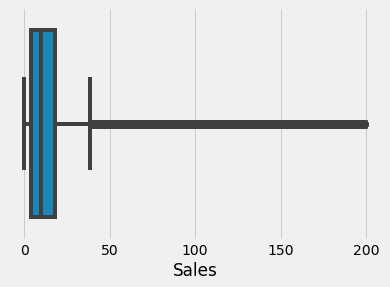

In [25]:
#display sales, the target variable, boxplot
sns.boxplot(df.Sales)

In [26]:
#There are many outliers 99% of sales is
df.Sales.quantile(0.99)

122.04

(996365, 17)


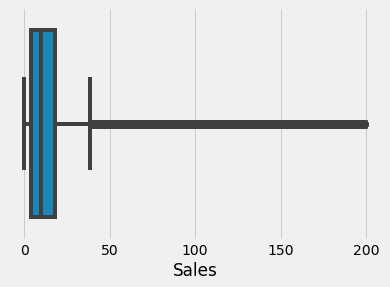

In [27]:
#remove all the 0 price because they are not sales, and keep 99% of the data
df = df[df.Sales != 0]

df = df[df.Sales<=200]
print(df.shape)
#boxplot of new sales variable
sns.boxplot(df.Sales);

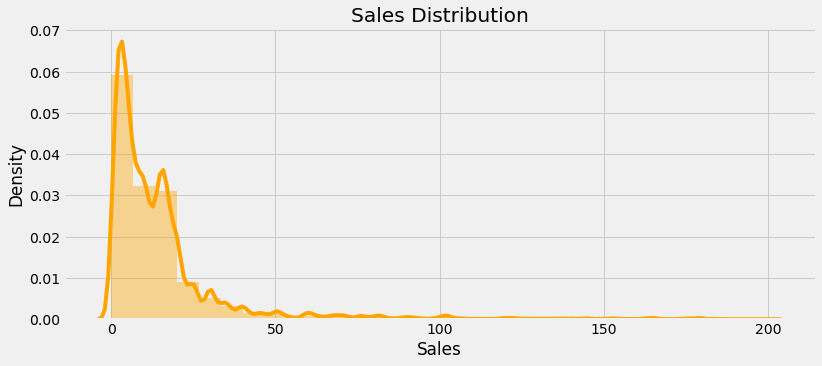

In [28]:
#plot Sales distribution
plt.figure(figsize=(12,5))
sns.distplot(df.Sales,bins=30,kde=True,color='orange')
plt.title('Sales Distribution');

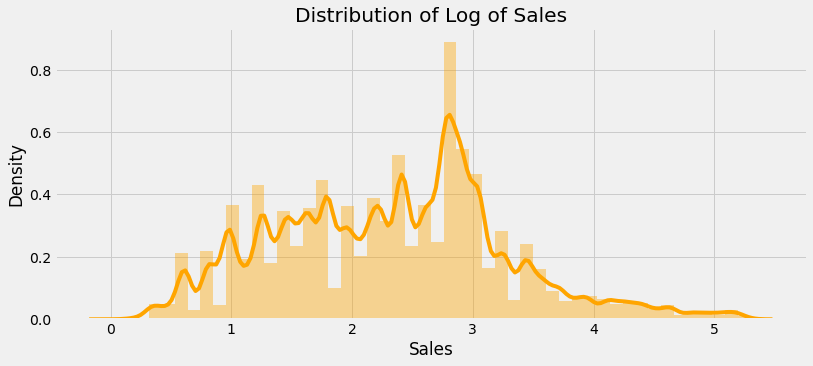

In [30]:
#log(x+1) of Sales 
plt.figure(figsize=(12,5))
sns.distplot(np.log1p(df.Sales),color='orange',kde=True)
plt.title('Distribution of Log of Sales');

>The distribution of log of sales has shorter right tail and looks closer to a normal distribution. 

>Kurtosis is a measure of the peakiness of a distribution, or is a measure of how heavy the tails are. So kurtosis of normal distribution is 0.0. If less than 0 then light tailed, greater than 0 the distribution is heavy tailed, or most of the data is in the tails. Skew is a measure of symmetry of the data. An absolute measurement between 0 and 0.5 for skew and kurtosis means the data is said to be symmetric 

In [31]:
#measure skew and kurtosis
print('skew = ', df.Sales.skew().round(2),'kurtosis= ',df.Sales.kurt().round(2))
print('skew log sales',(np.log1p(df.Sales)).skew().round(2),'kurtosis log sales= ',(np.log1p(df.Sales)).kurt().round(2))


skew =  4.08 kurtosis=  21.61
skew log sales 0.24 kurtosis log sales=  -0.15


<AxesSubplot:>

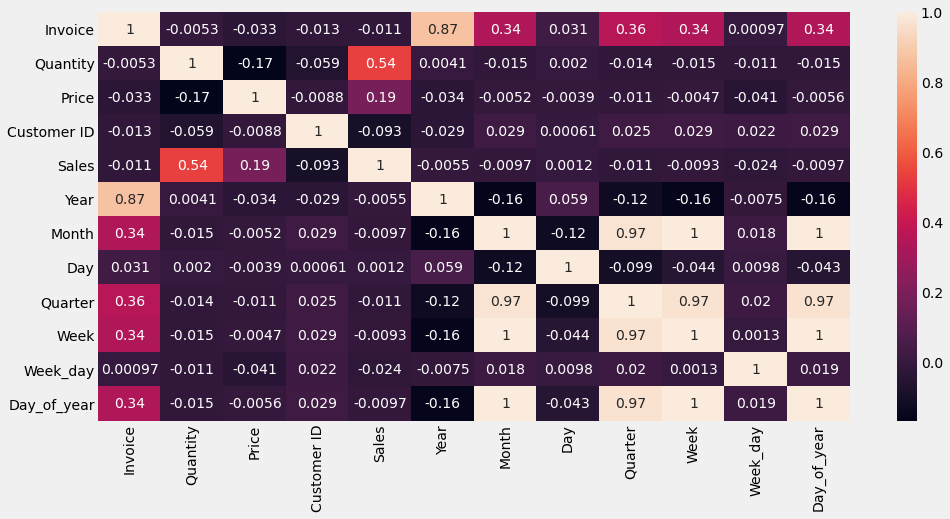

In [75]:
#look at correlation between variables
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=True)

>It is important that the features are not correlated. The target variable, Sales is not correlated with any other variable other than quantity, which makes sense since it is calculated using sales. The other time features are correlated which is expected in a datetime series. Next the features and target variables will be created. All the irrelevant features, like invoice, description and customer ID, will be dropped.

In [14]:
#create X and y variables
X = df[['Year','Month','Day','Quarter','Week','Week_day','Day_of_year']]
#scale the independent variable X
X_scaled = StandardScaler().fit_transform(X)
y = df['Sales'].values
y_log = np.log1p(df['Sales']).values

In [33]:
#create training and test datasets, one with y and another with log y
#I will test if the model performs better for the log of sales
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=123)
X_train,X_test,y_train_log,y_test_log = train_test_split(X_scaled,y_log,test_size=0.2,random_state=123)
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((797092, 7), (199273, 7), (797092,), (199273,))

In [83]:
#linear regression model, and the coefficient of determination for the training independent variable and 
#the training dependent variable to see how well the training data fit the response variable
lr_model = LinearRegression().fit(X_train,y_train)
lr_model.score(X_train,y_train)

0.0009125114249850519

In [84]:
#linear regression model for log y and score for log y
lr_model_log = LinearRegression().fit(X_train,y_train_log)
lr_model_log.score(X_train,y_train_log)


0.002454894862228163

>R squared value is very small which means that the model fits the data very poorly

In [499]:
#predict with model
y_pred = lr_model.predict(X_test)
y_pred_log = lr_model_log.predict(X_test)

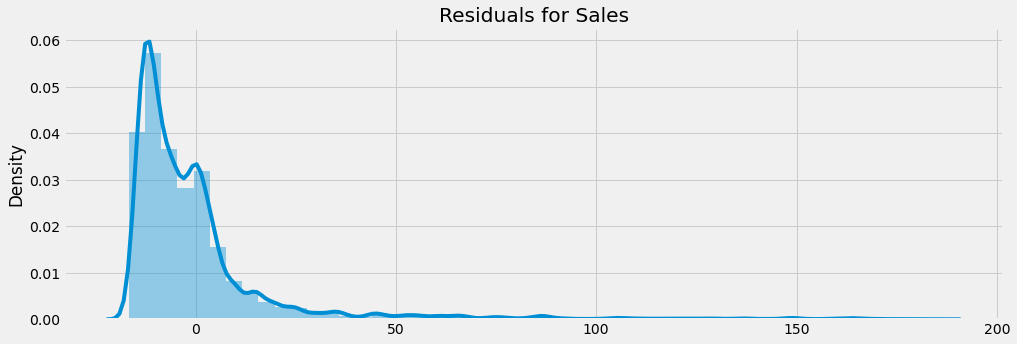

In [500]:
#plot residuals of sales
plt.figure(figsize=(15,5))
sns.distplot(y_test - y_pred)
plt.title('Residuals for Sales');

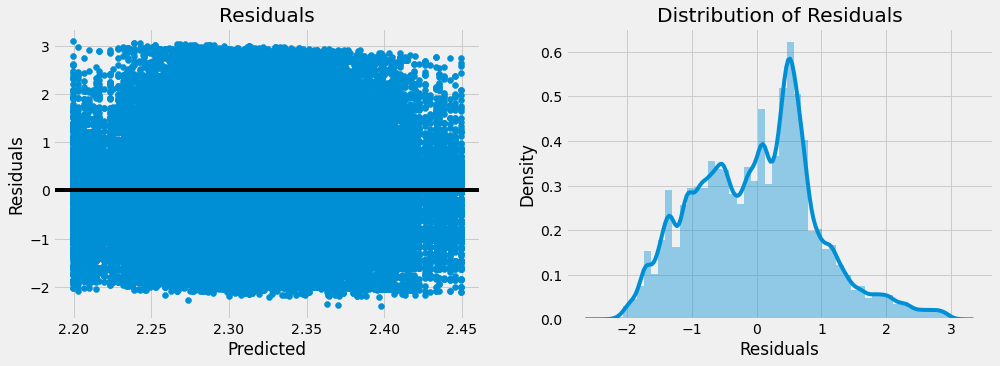

In [530]:
#plot residuals with log sales
f,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].axhline(y=0,color='black')
ax[0].scatter(y_pred_log,y_test_log - y_pred_log)

ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Residuals')
ax[0].set_title('Residuals')

sns.distplot(y_test_log - y_pred_log,ax=ax[1])
ax[1].set_xlabel('Residuals')
ax[1].set_title('Distribution of Residuals');

>I get better spread, closer to normal distribution residuals for log y. For residuals,since it is actual - predicted, positive values, which is on the y-axis, mean the prediction was too low, and negative values mean the prediction was too high; 0 means the prediction was exactly correct. Residuals are spread out around 0 with no pattern, which is what we want.

In [90]:
#function that take y and y predictions and 
#returns r_squared, MSE, RMSE, MAE
def metrics(y,y_pred):
    return 'r_square: ', r2_score(y,y_pred).round(5), \
        'MSE: ',mean_squared_error(y,y_pred).round(2), \
        'RMSE: ',np.sqrt(mean_squared_error(y,y_pred)).round(2),\
        'MAE: ',mean_absolute_error(y,y_pred).round(2)

In [91]:
#create an array of mean to test metrics if mean was our prediction to get a sense of values mean
y_mean = np.empty_like(y_test)
y_mean.fill(y.mean())

In [92]:
#metrics for y_test and prediction
print('y: ',metrics(y_test,y_pred))
#metrics for log y_test and predictions
print('log y: ',metrics(y_test_log,y_pred_log))
#metrics for y_test and if my prediction was the mean
print('mean y: ',metrics(y_test,y_mean))

y:  ('r_square: ', 0.00074, 'MSE: ', 454.55, 'RMSE: ', 21.32, 'MAE: ', 11.94)
log y:  ('r_square: ', 0.00224, 'MSE: ', 0.89, 'RMSE: ', 0.94, 'MAE: ', 0.77)
mean y:  ('r_square: ', -0.0, 'MSE: ', 454.88, 'RMSE: ', 21.33, 'MAE: ', 11.94)


>Looking at the metrics it is apparent that using y without laking the log is worse than using the mean as prediction. Using log y gives better results, but coefficient of determination is small, indicating that the model fits the data very badly. The RMSE is smaller for log y

In [111]:
#I will use the statsmodel ordinary least squares model
X_train_sm = sm.add_constant(X_train)
model_ols = sm.OLS(y_train_log, X_train_sm).fit() #formula='Sales ~ TV', data=data
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     280.2
Date:                Thu, 05 Aug 2021   Prob (F-statistic):               0.00
Time:                        01:19:29   Log-Likelihood:            -1.0856e+06
No. Observations:              797092   AIC:                         2.171e+06
Df Residuals:                  797084   BIC:                         2.171e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3183      0.001   2191.239      0.0

>The coefficients for each feature in X all have a very small p_value, which means they are statistically significant 
>Like in the linear regression R_squared is very small, which means that the X features explain only 0.3 of the variance of the sales. The p of F_statistic is significant. F_statistic is the ratio of mean squared error of the model to the mean squared error of residuals. It determines the overall significance of the model.It tests if the coefficient are significant jointly and in this case they are.
>As expected the linear regression is not a good model for predicting sales

<a id='lrhypertune'></a>
#### Hyperparameter tuning

In [112]:
#cross validation
lr_results = cross_val_score(lr_model_log, X_train, y_train_log, cv=5, \
                     scoring= 'r2')
lr_results

array([0.00270739, 0.00242754, 0.00281071, 0.00222809, 0.00197636])

>I don't get better results. R2 is still very low

[Back to Menu](#menu)

<a id = 'knn'></a>
### KNearest Neighbor

>Knearest Neighbor is a model that adapts well to classification and regression. It is also easy to implement and to interpret. However, one drawback is its inability to adapt to highly complex relationships between the independent and dependent variables. So I will test it and see how it will perform

<AxesSubplot:>

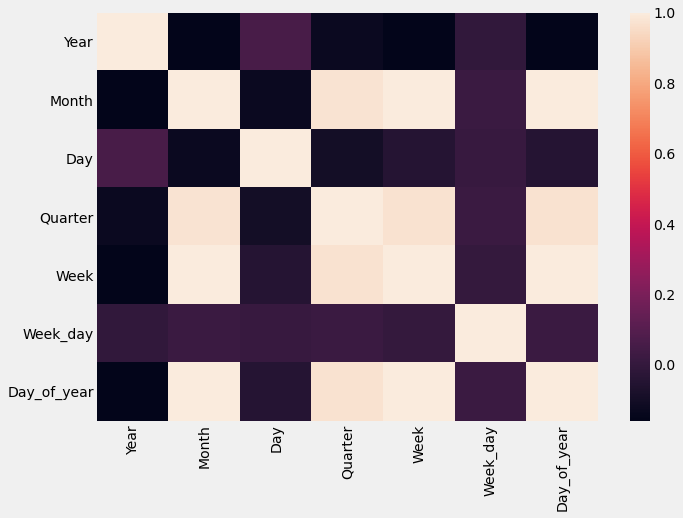

In [113]:
plt.figure(figsize=(10,7))
sns.heatmap(X.corr())

>The randomizedSearch is taking too long because my data is too big so I will reduce it to year 2011 since both years have the same trends more or less 

In [116]:
df_reduced = df[df.Year ==2011]
X_reduced = df_reduced[['Year','Month','Day','Quarter','Week','Week_day','Day_of_year']]
#scale the independent variable X_reduced
X_scaled_red = StandardScaler().fit_transform(X_reduced)

y_log_red = np.log1p(df_reduced['Sales']).values
len(y_log_red)

475491

In [117]:
#create training and test datasets, one with y and another with log y
X_train_red,X_test_red,y_train_red,y_test_red = train_test_split(X_scaled_red,y_log_red,test_size=0.2,random_state=123)

X_train_red.shape,X_test_red.shape,y_train_red.shape,y_test_red.shape


((380392, 7), (95099, 7), (380392,), (95099,))

In [118]:
#paramaters to be tuned for kneighbors regressor are the number of neighbors and if the closest points get more weight
#(distance) or no weight (uniform)
seed=123
kfold =KFold(n_splits=5,shuffle=True,random_state=seed)  #shuffle=True,
param_grid={"n_neighbors": range(1, 20),'weights':['uniform','distance']}

knn = KNeighborsRegressor()

grid_knn = RandomizedSearchCV(knn, param_distributions=param_grid,cv=3,scoring='r2',
                             n_jobs=-1,verbose=10)
#grid_knn_2 = RandomizedSearchCV(knn, param_distributions=param_grid_2,cv=3,scoring='neg_root_mean_squared_error',n_jobs=-1,verbose=10)

knn_model = grid_knn.fit(X_train_red,y_train_red)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [119]:
#best parameters
knn_model.best_params_


{'weights': 'uniform', 'n_neighbors': 18}

In [120]:
#predict
y_pred_knn = knn_model.predict(X_test_red)
metrics(y_test_red,y_pred_knn)

('r_square: ', -0.01924, 'MSE: ', 0.93, 'RMSE: ', 0.96, 'MAE: ', 0.78)

>r2 is negative but the errors are reduced with MAE at 0.79, lets look at the residuals

count    95099.000000
mean        -0.012100
std          0.964779
min         -2.925607
25%         -0.717463
50%          0.022885
75%          0.612114
max          3.614996
dtype: float64


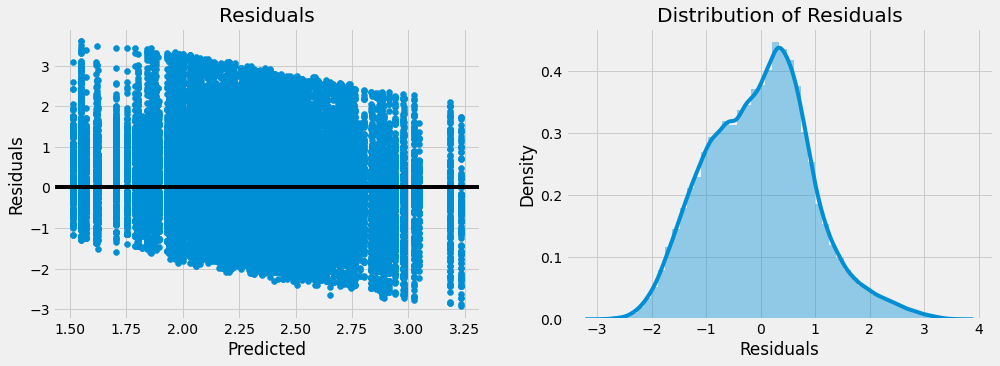

In [531]:
#plot residuals vs actual
f,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].axhline(y=0,color='black')
ax[0].scatter(y_pred_knn, y_test_red-y_pred_knn)
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Residuals')
ax[0].set_title('Residuals')

sns.distplot(y_test_red-y_pred_knn, ax=ax[1])
ax[1].set_xlabel('Residuals')
ax[1].set_title('Distribution of Residuals')
print(pd.Series(y_test_red-y_pred_knn).describe());

>There is a clear pattern, which means that the model does not work for the data, however, the distribution of residuals are almost normal centered around 0.01, so they are almost normally distributed but model is predicting very badly.

[Back to Menu](#menu)

<a id='rf'></a>
### RandomForestRegressor

In [125]:
# Number of trees in random forest
n_estimators = [200,400,800] #[int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]#num is number of samples to generate
# Minimum number of samples required to split a node
min_samples_split = [2,5,10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

params_rf = {'n_estimators':n_estimators,
            'max_features':max_features,
            'max_depth':max_depth,
            'min_samples_split':min_samples_split,
            'min_samples_leaf':min_samples_leaf}
print(params_rf)

{'n_estimators': [200, 400, 800], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [126]:
#run RandomizedSearc with the parameter grid then fit to data
rf = RandomForestRegressor()
grid_random_forest = RandomizedSearchCV(estimator=rf,param_distributions=params_rf,
                                        scoring='neg_root_mean_squared_error',
                                       n_iter=10, verbose=10,n_jobs=-1, cv=3)
rf_model = grid_random_forest.fit(X_train_red,y_train_red)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [127]:
#predict with rf_model
y_pred_rf = rf_model.predict(X_test_red)
metrics(y_test_red,y_pred_rf)

('r_square: ', 0.0412, 'MSE: ', 0.88, 'RMSE: ', 0.94, 'MAE: ', 0.76)

count    95099.000000
mean        -0.001101
std          0.935810
min         -2.506287
25%         -0.703630
50%          0.039520
75%          0.598484
max          3.375207
dtype: float64


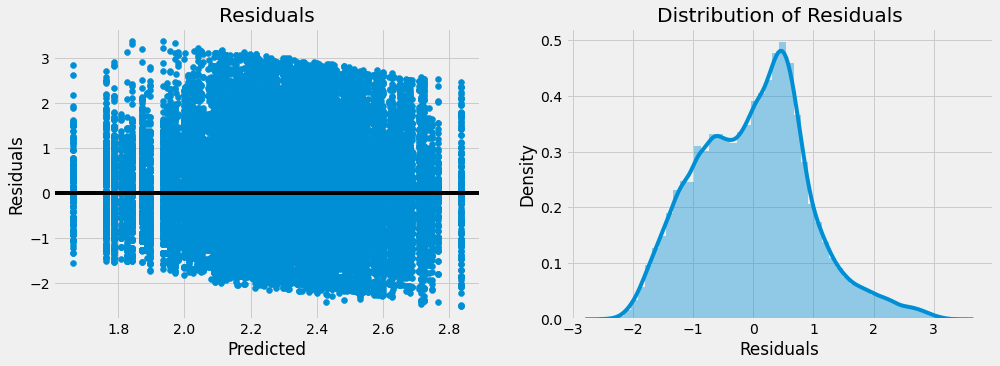

In [532]:
#plot residuals vs actual
f,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].axhline(y=0,color='black')
ax[0].scatter(y_pred_rf, y_test_red - y_pred_rf)
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Residuals')
ax[0].set_title('Residuals')

sns.distplot(y_test_red-y_pred_rf, ax=ax[1])
ax[1].set_xlabel('Residuals')
ax[1].set_title('Distribution of Residuals')
print(pd.Series(y_test_red-y_pred_rf).describe());

>Again there are patterns in residual plot so the model is not predicting well and it needs to be improved. This is expected because ensemble methods don't do well with datetime series, The residuals are almost normally distributed and centered around -0.001.  I will add more features and explore how to improve predictions using these models in the another notebook

In [132]:
#metrics for the three models
print('Linear Regression: ',metrics(y_test_log,y_pred_log),
    '\nnearest neighbor:',metrics(y_test_red,y_pred_knn),
    '\nRandom Forest: ',metrics(y_test_red,y_pred_rf))

Linear Regression:  ('r_square: ', 0.00224, 'MSE: ', 0.89, 'RMSE: ', 0.94, 'MAE: ', 0.77) 
nearest neighbor: ('r_square: ', -0.01924, 'MSE: ', 0.93, 'RMSE: ', 0.96, 'MAE: ', 0.78) 
Random Forest:  ('r_square: ', 0.0412, 'MSE: ', 0.88, 'RMSE: ', 0.94, 'MAE: ', 0.76)


>random forest gave better scores than knn and linear regression with slightly better r2 and errors. However, looking at residual plots, linear regression gave the best prediction. The R2 is low for all models, which means that variance of the dependent variable(sales) is not well explained by the variance of the independent variables in my data, so more features could be added to improve the score, like lags, however I will try ARIMA and see if it performs better.

[Menu](#menu)
<a id='arima'></a>
### Autoregressive Integrated Moving Average or ARIMA

> ARIMA the most commonly used method for time-series forecasting.
>In order to use ARIMA model, I need to ensure that the time series data is stationary, meaning constant mean, constant variance and constant covariance with time. A time series is stationary if a single shift in time does not change the time series statistical properties. The reason for this is that the term AR means Auto Regressive, which means it is a linear regression model that uses its own lags as predictors. Linear regression models, work best when the predictors are not correlated and are independent of each other.  

>There are two ways to test if a dataseries is stationary  
        1. Rolling mean  
        2. Dicky_Fuller_test

In [15]:
#copy the dataframe
df_data = df.copy()
df_data.InvoiceDate = pd.to_datetime(df_data.InvoiceDate)

In [16]:
#change index to be the dates without the time
df_data = df_data.set_index('InvoiceDate')#InvoiceDate has time
df_data.index = df_data.index.normalize()#gets rid of time stamp
df_data.head(2)

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,Date,Sales,Year,Month,Day,Quarter,Week,Week_day,Day_of_year
InvoiceDate,,,,,,,,,,,,,,,,
2009-12-01,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085.0,United Kingdom,2009-12-01 00:00:00,83.4,2009,12,1,4,49,1,335
2009-12-01,489434,79323P,PINK CHERRY LIGHTS,12,6.75,13085.0,United Kingdom,2009-12-01 00:00:00,81.0,2009,12,1,4,49,1,335


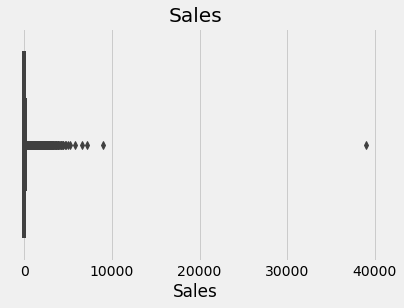

In [17]:
#create a df with only sales
df_sales = df_data[['Sales']]
sns.boxplot(df_sales.Sales)
plt.title('Sales');

<AxesSubplot:xlabel='Sales', ylabel='Density'>

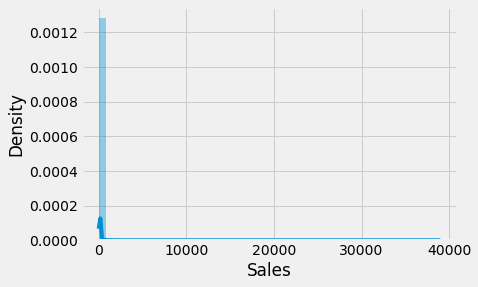

In [42]:
sns.distplot(df_sales.Sales,kde=True)

In [18]:
low_sales = df_sales.Sales.quantile(0.01)
high_sales = df_sales.Sales.quantile(0.99)
low_sales, high_sales

(0.65, 179.0)

In [19]:
df_sales = df_sales.loc[(df_sales.Sales >= low_sales) & (df_sales.Sales <= high_sales)]
df_sales.min(), df_sales.max(), df_sales.shape

(Sales    0.65
 dtype: float64,
 Sales    179.0
 dtype: float64,
 (978478, 1))

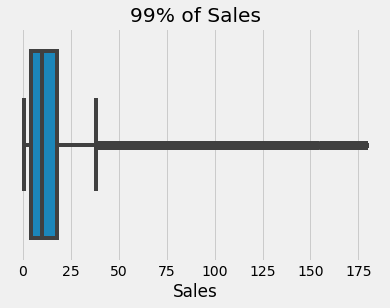

In [20]:
sns.boxplot(df_sales.Sales)
plt.title('99% of Sales');

<AxesSubplot:xlabel='InvoiceDate'>

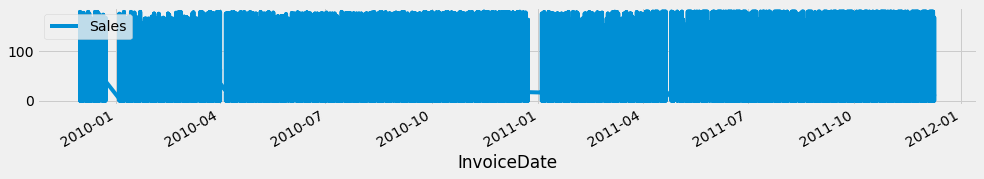

In [29]:

#visualize
df_sales.plot(figsize=(15,2))

## ARIMA

ARIMA is a class of models that explains a given time series based on its own past values, 
Arima stands for Autoregressive Integrated Moving Average, which means the following:
AR: stands for Autoregression, which means a model that uses the dependent relationship between an observation and some number of lagged observations.  
I: Integrated which means subtracting an observation from an observation at the previous time step in order to make the time series stationary, meaning differencing  
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

There are three parameters that need to be tuned:
- p is the number of lags of Y to be used as predictors
- d is the minimum number of differencing needed to make the series stationary. A d =0 means the series is stationary 
- q refers to the number of lagged forecast errors that should go into the Model.

First thing is to see if the series is stationary

### To test if series is stationary there are two tests:
1. Rolling mean: 
The window of one week is rolled across the data and an average is taken. Then I can compare the original data with the rolled data and check if the data is stationary or not by visualization. If original data and rolled data look similar, it means that the mean and variation do not change over time and that they are constant, so no transformation is necessary
2. Augmented Dicky Fuller test

### Rolling mean test

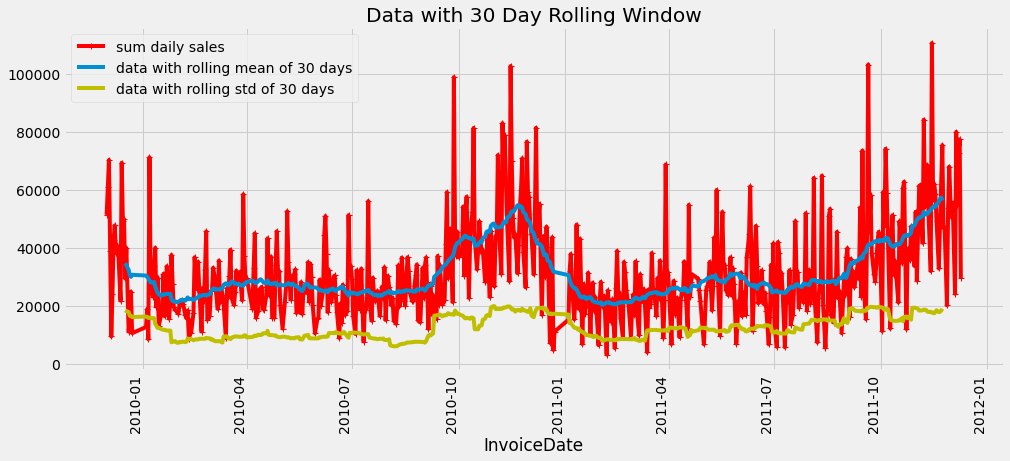

In [21]:
#to visualize the trends in the data, I used sum of daily sales and used a 20 day rolling window
plt.figure(figsize=(15,7))
df_data_plot = df_data.reset_index().groupby('InvoiceDate').Sales.sum()
df_data_plot.plot(marker='+',c='r',label='sum daily sales')
plt.plot(df_data_plot.rolling(window=30,center=True).mean(),label='data with rolling mean of 30 days')
plt.plot(df_data_plot.rolling(window=30,center=True).std(),c='y',label='data with rolling std of 30 days')

plt.xticks(rotation=90)
plt.title('Data with 30 Day Rolling Window')
plt.legend();

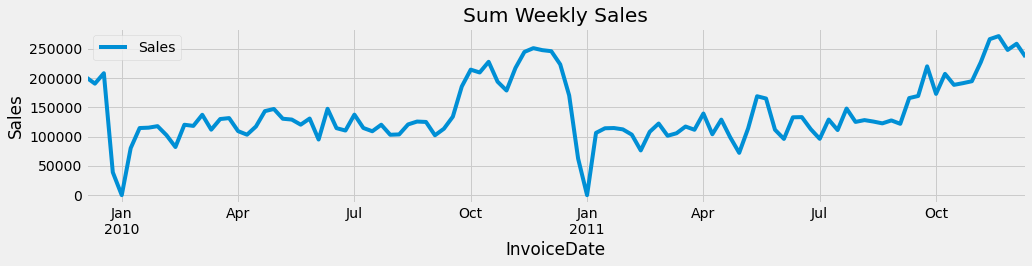

In [32]:
#resample weekly and plot 
df_sales.resample('W').sum().plot(figsize=(15,3))
plt.title('Sum Weekly Sales')
plt.ylabel('Sales');

>sales tend to peak at the end of the year then go down in January, so there are trends in the data

In [255]:
"""
#plot the rolling mean and std for weekly sampled data

plt.figure(figsize=(12,5))
original = plt.plot(df_sales.resample('W').sum(),color='blue',label='original')
mean = plt.plot(df_sales.resample('W').sum().rolling(window=6).mean(),color='red',label='Rolling Mean',alpha=0.5)
std = plt.plot(df_sales.resample('W').sum().rolling(window=6).std(),color='black',label='Rolling STD')
plt.legend()
plt.ylabel('Average Sales')
plt.title('Comparing Rolled mean and std to original data');
"""

"\n#plot the rolling mean and std for weekly sampled data\n\nplt.figure(figsize=(12,5))\noriginal = plt.plot(df_sales.resample('W').sum(),color='blue',label='original')\nmean = plt.plot(df_sales.resample('W').sum().rolling(window=6).mean(),color='red',label='Rolling Mean',alpha=0.5)\nstd = plt.plot(df_sales.resample('W').sum().rolling(window=6).std(),color='black',label='Rolling STD')\nplt.legend()\nplt.ylabel('Average Sales')\nplt.title('Comparing Rolled mean and std to original data');\n"

[Menu](#menu)
<a id = dicky_fuller></a>
### The Dicky_Fuller_test: 
it tests the null hypothesis that the data is not stationary and the alternative hypothesis is that the data is stationary. If the p-value is less than the critical value, 0.05 I will reject the null hypothesis and say that data is stationary.

In [22]:
#Dicky_Fuller_test
df_sales_d = df_sales.resample('d').sum()
result = adfuller(df_sales_d, autolag='AIC')
print('ADF Statistic={}\np_value= {}\n'.format(result[0],result[1]))
print('Critical Values = ' ,result[4])

ADF Statistic=-2.327910270300503
p_value= 0.16312427395093182

Critical Values =  {'1%': -3.439490435810785, '5%': -2.8655738086413374, '10%': -2.568918067209286}


>From the graph the rolling mean shows that the data has trends and is not stationary. From the Dicky_Fuller test the ADF statistic is above 5% critical value and its p_value is 0.17 which makes it not significant. This means that I can not reject the null hypothesis that the series is not stationary. So differencing needs to be performed on the data to make it stationary.

In [23]:
#Dicky_Fuller_test of differenced series
result = adfuller(df_sales_d.diff().dropna(), autolag='AIC')
print('ADF Statistic={}\np_value= {}\n'.format(result[0],result[1]))
print('Critical Values = ' ,result[4])

ADF Statistic=-9.397739296239017
p_value= 6.307470781109976e-16

Critical Values =  {'1%': -3.439490435810785, '5%': -2.8655738086413374, '10%': -2.568918067209286}


> The test shows a significant p_value which means that we can reject the null hypothesis and determine the series is stationary.

P value is determined from the pacf plot  
q value is determined from the acf plot

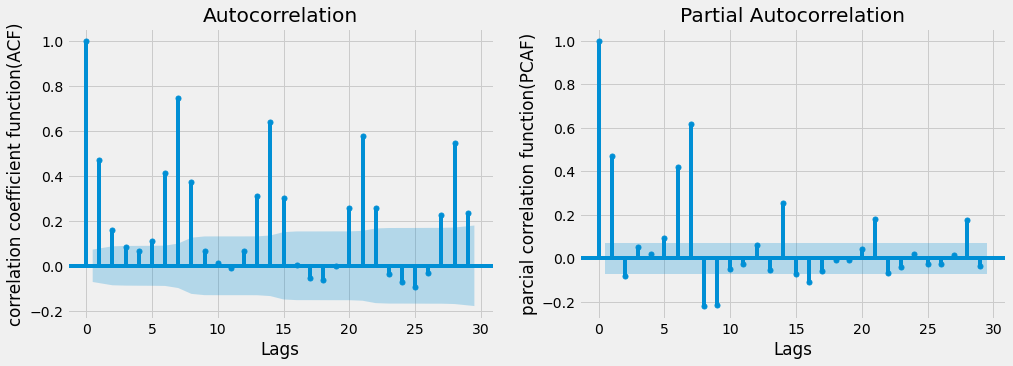

In [35]:
#autocorrelation function or ACF graph
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#The ACF plot tells how many MA terms are required to remove any autocorrelation in the stationarized series, which is q
f,ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(df_sales_d.values,ax=ax[0])
ax[0].set_xlabel('Lags')
ax[0].set_ylabel('correlation coefficient function(ACF)')
#To find out need needs any AR terms or p by inspecting the Partial Autocorrelation (PACF) plot.
plot_pacf(df_sales_d.values,ax=ax[1])
plt.xlabel('Lags')
plt.ylabel('parcial correlation function(PCAF)');

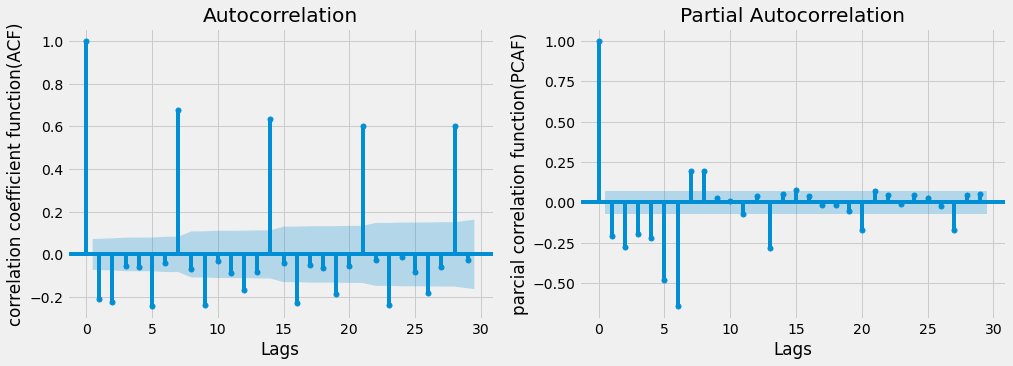

In [36]:
#autocorrelation function or ACF graph

#The ACF plot tells how many MA terms are required to remove any autocorrelation in the stationarized series, which is q
f,ax = plt.subplots(1,2,figsize=(15,5))
plot_acf(df_sales_d.diff().dropna().values,ax=ax[0])
ax[0].set_xlabel('Lags')
ax[0].set_ylabel('correlation coefficient function(ACF)')
#To find out need needs any AR terms or p by inspecting the Partial Autocorrelation (PACF) plot.
plot_pacf(df_sales_d.diff().dropna().values,ax=ax[1])
plt.xlabel('Lags')
plt.ylabel('parcial correlation function(PCAF)');

>The Autocorrelation function (ACF) plot shows how a given time series is correlated with itself.
Autocorrelation refers to how correlated a time series is with its past values, the ACF is the plot used to see the correlation between the points, up to and including the lag unit. From the ACF graph the time series is significantly positively correlated with its past values at 1,2 and 3 lags.
>Partial correlation is a conditional correlation. It is a summary of the relationship between an observation with observations at prior time steps. Here lag 1 is significant. Also, when auto-correlation decrease too fast it may indicate over_differencing and if it decrease too slow(stays positive for more than 10 lags) it indicates under-differencing. In the graph above, the autocorrelation decreases slowly up to 9 lags.
From the PACF we get the AR or p term, from ACF we get the MA or q term. So the model will be run with p= 1, q=2, and d=1.

>There is drop of positive correlation from 1 to 3 so it makes sense to use q=2 as a starting point 

>Create training and test sets that are 75/25 of data. The order of the data need to be kept because the 
order sequence of the time series should be intact in order to use it for forecasting.
ARIMA has a forecast function that, by default, this function makes a single step out-of-sample forecast. As such, we can call it directly and make our forecast. The result of the forecast() function is an array containing the forecast value, the standard error of the forecast, and the confidence interval information.

RMSE=  18524.546938632004
MAE=  15036.564749089603


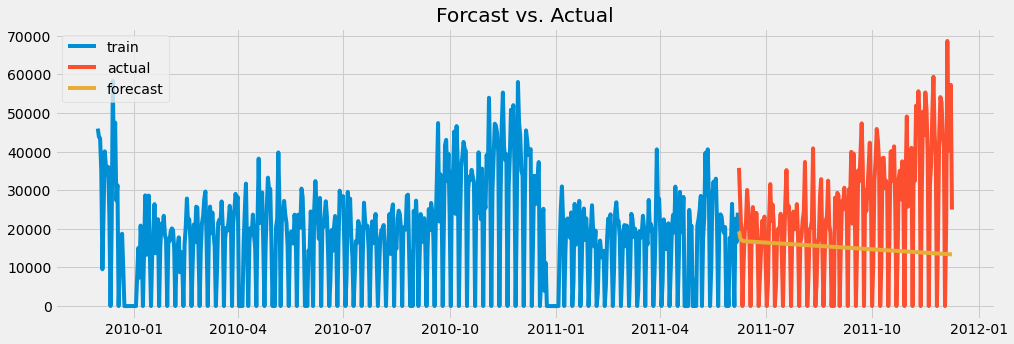

In [24]:
#create training and test sets that are 75/25 of data. The order of the data need to be kept because the 
#order sequence of the time series should be intact in order to use it for forecasting.


X = df_sales_d.values
size = int(len(df_sales_d)*0.75)
train, test = X[0:size], X[size:len(X)]
predictions = []
model = ARIMA(train, order=(1,1,1))
model_arima = model.fit()
fc, er, ci = model_arima.forecast(len(test))#forecast 15 steps
fc_series = pd.Series(fc, index=df_sales_d[size:].index)
print('RMSE= ',np.sqrt(mean_squared_error(test, fc)))
print('MAE= ',mean_absolute_error(test,fc))
#plot forcast
plt.figure(figsize=(15,5))
plt.plot(df_sales_d[0:size], label='train')
plt.plot(df_sales_d[size:], label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forcast vs. Actual')
plt.legend();

In [38]:
print(model_arima.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  553
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5935.458
Method:                       css-mle   S.D. of innovations          11081.378
Date:                Fri, 08 Oct 2021   AIC                          11878.916
Time:                        11:54:21   BIC                          11896.178
Sample:                             1   HQIC                         11885.660
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.0147     51.230     -0.371      0.711    -119.423      81.393
ar.L1.D.y      0.3388      0.047      7.157      0.000       0.246       0.432
ma.L1.D.y     -0.9301      0.020    -46.198      0.0

>forcast is not great so now I need to find the best values for p, d, and q

[Menu](#menu)
<a id=optimize_model></a>
### Optemize ARIMA Model

In [25]:
"""
Function that takes training, test sets and a list of values for p, d and q to test
Function loops through the values of p, d and q and creates a tuple of these values and calls evaluate_arima 
    that returns the root mean square error and then print the p,d,q for the model that gave the least RMSE
"""
def evaluate_model(train, test, p_val, d_val, q_val):
    #intialize best score to a large value
    best_score, best_mae, best_pdq_se, best_pdq_ae = float('inf'), float('inf'), (),()
    for p in p_val:
        for d in d_val:
            for q in q_val:
                order=(p,d,q)
                
                try:
                    #run arima
                    rmse, mae=evaluate_arima(train, test, order)
                    #get error
                    if rmse < best_score:
                        best_score, best_pdq_se = rmse, order
                    if mae < best_mae:
                        best_mae,best_pdq_ae = mae, order
                        
                        #print the order and its error
                    print('ARIMA order: {}, RMSE: {}'.format(order,rmse))
                    print('Arima order: {}, MAE: {}'.format(order,mae))
                except:
                    continue
    print('Best ARIMA order: {} with error = {}'.format(best_pdq_se, best_score))
    print('Best ARIMA order: {} with absolute error = {}'.format(best_pdq_ae, best_mae))
                    

In [26]:
"""
Function takes in training and test sets and a tuple of p,d,q for arima model and fits and predicts 
returns the root mean squared error
"""
def evaluate_arima(train, test, order):
    #all_data = train
   
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    fc = model_fit.forecast(len(test))[0]
    rmse = np.sqrt(mean_squared_error(test, fc))
    mae=mean_absolute_error(test,fc)
   
    return rmse,mae



In [43]:
#call evaluate_model to iterate through values for p,d,q to a model with least RMSE
# create train and test set
X = df_sales_d.values
size = int(len(df_sales_d)*0.75)
train, test = X[0:size], X[size:len(X)]

#list of p, d and q values
p_values = [1, 2, 3, 4, 6, 8, 10,12,15]
d_values = range(0, 4)
q_values = range(0, 4)

#run function
evaluate_model(train,test,p_values, d_values, q_values)

ARIMA order: (1, 0, 0), RMSE: 16414.4261536635
Arima order: (1, 0, 0), MAE: 13184.060722086875
ARIMA order: (1, 0, 1), RMSE: 16411.516362206366
Arima order: (1, 0, 1), MAE: 13180.485080217051
ARIMA order: (1, 0, 2), RMSE: 16673.884244496123
Arima order: (1, 0, 2), MAE: 13482.058290610135
ARIMA order: (1, 0, 3), RMSE: 16410.732233780134
Arima order: (1, 0, 3), MAE: 13227.441136128171
ARIMA order: (1, 1, 0), RMSE: 17341.886228083713
Arima order: (1, 1, 0), MAE: 13801.310422055509
ARIMA order: (1, 1, 1), RMSE: 18524.546938632004
Arima order: (1, 1, 1), MAE: 15036.564749089603
ARIMA order: (1, 1, 2), RMSE: 18818.996536389328
Arima order: (1, 1, 2), MAE: 15278.466023505684
ARIMA order: (1, 1, 3), RMSE: 20489.436691546234
Arima order: (1, 1, 3), MAE: 16657.69015727391
ARIMA order: (1, 2, 0), RMSE: 456054.2569466463
Arima order: (1, 2, 0), MAE: 384504.8317656038
ARIMA order: (2, 0, 0), RMSE: 16412.038709398697
Arima order: (2, 0, 0), MAE: 13181.012096159115
ARIMA order: (2, 0, 1), RMSE: 16391

ARIMA order: (15, 0, 0), RMSE: 15584.732239280753
Arima order: (15, 0, 0), MAE: 12149.37397311296
ARIMA order: (15, 0, 1), RMSE: 15436.281947142912
Arima order: (15, 0, 1), MAE: 12007.651372245817
ARIMA order: (15, 1, 0), RMSE: 18073.432946956662
Arima order: (15, 1, 0), MAE: 13911.266279752454
ARIMA order: (15, 1, 1), RMSE: 17868.96354224949
Arima order: (15, 1, 1), MAE: 13792.004397462064
ARIMA order: (15, 1, 2), RMSE: 17702.291280716963
Arima order: (15, 1, 2), MAE: 13640.100210995342
ARIMA order: (15, 1, 3), RMSE: 15245.251634375616
Arima order: (15, 1, 3), MAE: 11491.62813252603
ARIMA order: (15, 2, 1), RMSE: 12439.511828962894
Arima order: (15, 2, 1), MAE: 9380.410103906173
ARIMA order: (15, 2, 2), RMSE: 12569.888631878059
Arima order: (15, 2, 2), MAE: 9489.970481507346
ARIMA order: (15, 2, 3), RMSE: 12608.068251487863
Arima order: (15, 2, 3), MAE: 9294.887886340211
Best ARIMA order: (15, 2, 1) with error = 12439.511828962894
Best ARIMA order: (15, 2, 3) with absolute error = 929

In [28]:
p_values = [15,16,18,20,22]
d_values = range(1,3)
q_values = range(0, 7)

evaluate_model(train,test,p_values, d_values, q_values)

ARIMA order: (15, 1, 0), RMSE: 18073.432946956662
Arima order: (15, 1, 0), MAE: 13911.266279752454
ARIMA order: (15, 1, 1), RMSE: 17868.96354224949
Arima order: (15, 1, 1), MAE: 13792.004397462064
ARIMA order: (15, 1, 2), RMSE: 17702.291280716963
Arima order: (15, 1, 2), MAE: 13640.100210995342
ARIMA order: (15, 1, 3), RMSE: 15245.251634375616
Arima order: (15, 1, 3), MAE: 11491.62813252603
ARIMA order: (15, 1, 4), RMSE: 14074.80726492868
Arima order: (15, 1, 4), MAE: 10479.465369113024
ARIMA order: (15, 1, 5), RMSE: 13755.98399011723
Arima order: (15, 1, 5), MAE: 10279.739809105433
ARIMA order: (15, 1, 6), RMSE: 14289.19643453605
Arima order: (15, 1, 6), MAE: 10641.334272056518
ARIMA order: (15, 2, 1), RMSE: 12439.511828962894
Arima order: (15, 2, 1), MAE: 9380.410103906173
ARIMA order: (15, 2, 2), RMSE: 12569.888631878059
Arima order: (15, 2, 2), MAE: 9489.970481507346
ARIMA order: (15, 2, 3), RMSE: 12608.068251487863
Arima order: (15, 2, 3), MAE: 9294.887886340211
ARIMA order: (16, 

In [72]:
#Run ARIMA with the new optimized values

model = ARIMA(train, order=(8,2,1))
model_fit = model.fit()
fc,se, conf_int = model_fit.forecast(steps=len(test))
print('RMSE',np.sqrt(mean_squared_error(test,fc)).round(2))
print('mae',mean_absolute_error(test,fc))

forecast = pd.Series(fc, index = df_sales_d.index[size:])
lower_val = pd.Series(conf_int[:,0], index = df_sales_d.index[size:])
upper_val = pd.Series(conf_int[:,1], index = df_sales_d.index[size:])

RMSE 13371.28
mae 9725.751039708819


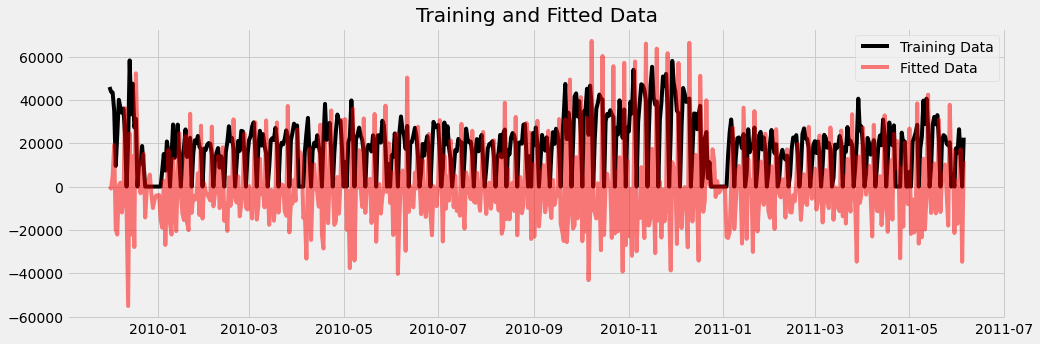

In [74]:
#ploting how the fitting looks like on the train data
model_fit = model.fit()
fitted_values = pd.Series(model_fit.fittedvalues, index = df_sales_d.index[0:train.shape[0]-2])
plt.figure(figsize=(15,5))
plt.plot(df_sales_d[:train.shape[0]-2],color='black',label='Training Data')
plt.plot(fitted_values,color='red',alpha=0.5,label='Fitted Data')
plt.legend()
plt.title('Training and Fitted Data');

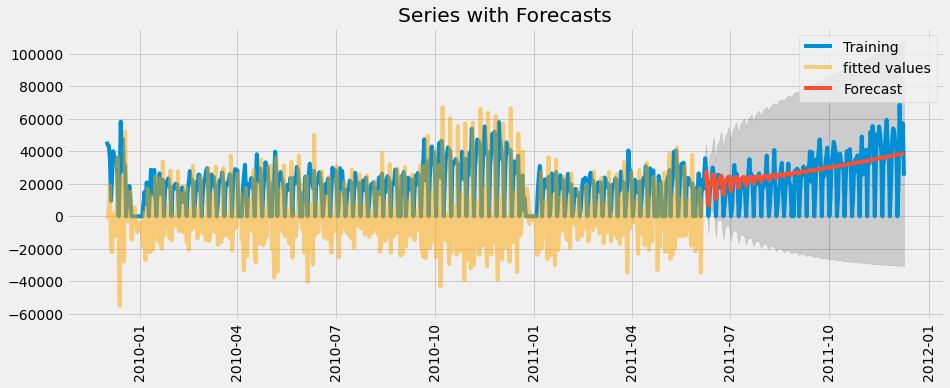

In [68]:
#plot forcast
plt.figure(figsize=(14,5))
plt.plot(df_sales_d, label='Training')
plt.plot(fitted_values,color='orange',alpha=0.5,label='fitted values')
plt.plot(forecast, label='Forecast')

plt.fill_between(lower_val.index, lower_val, upper_val, color='k', alpha=.15)
plt.xticks(rotation=90)
plt.title('Series with Forecasts')
plt.legend();

In [75]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  552
Model:                 ARIMA(8, 2, 1)   Log Likelihood               -5742.522
Method:                       css-mle   S.D. of innovations           7876.362
Date:                Tue, 12 Oct 2021   AIC                          11507.043
Time:                        13:15:29   BIC                          11554.492
Sample:                             2   HQIC                         11525.583
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3735      0.667      0.560      0.575      -0.934       1.681
ar.L1.D2.y    -0.6185      0.042    -14.732      0.000      -0.701      -0.536
ar.L2.D2.y    -0.4739      0.047     -9.989      0.0

In [76]:
#Run ARIMA with the new optimized values (18,1,6)
model_2 = ARIMA(train, order=(18,1,6))
model_fit_2 = model_2.fit()
fc_2,se_2, conf_int_2 = model_fit_2.forecast(steps=len(test))
print('RMSE',np.sqrt(mean_squared_error(test,fc_2)).round(2))
print('mae',mean_absolute_error(test,fc_2))

forecast_2 = pd.Series(fc_2, index = df_sales_d.index[size:])
lower_val_2 = pd.Series(conf_int_2[:,0], index = df_sales_d.index[size:])
upper_val_2 = pd.Series(conf_int_2[:,1], index = df_sales_d.index[size:])

RMSE 10879.17
mae 8727.111649224153


In [84]:
model_fit_2.fittedvalues.shape

(553,)

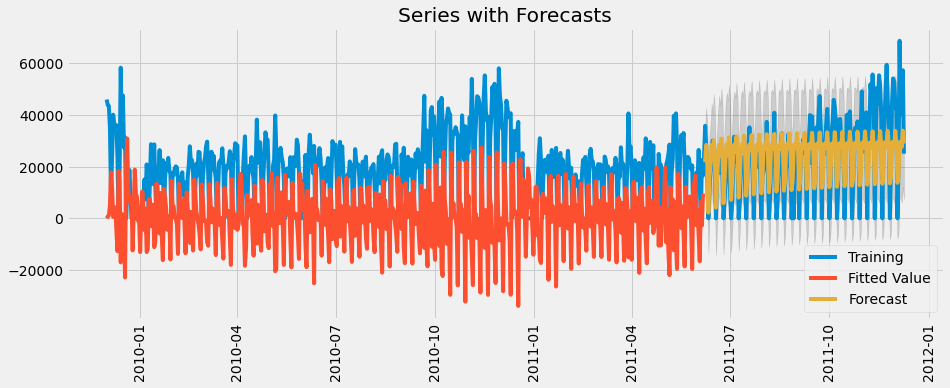

In [87]:
#plot forcast
fitted_values_2 = pd.Series(model_fit_2.fittedvalues, index = df_sales_d.index[0:train.shape[0]-1])
plt.figure(figsize=(14,5))
plt.plot(df_sales_d, label='Training')
plt.plot(fitted_values_2,label='Fitted Value')
plt.plot(forecast_2, label='Forecast')

plt.fill_between(lower_val_2.index, lower_val_2, upper_val_2, color='k', alpha=.15)
plt.xticks(rotation=90)
plt.title('Series with Forecasts')
plt.legend();

>The forecasts are trending up. 

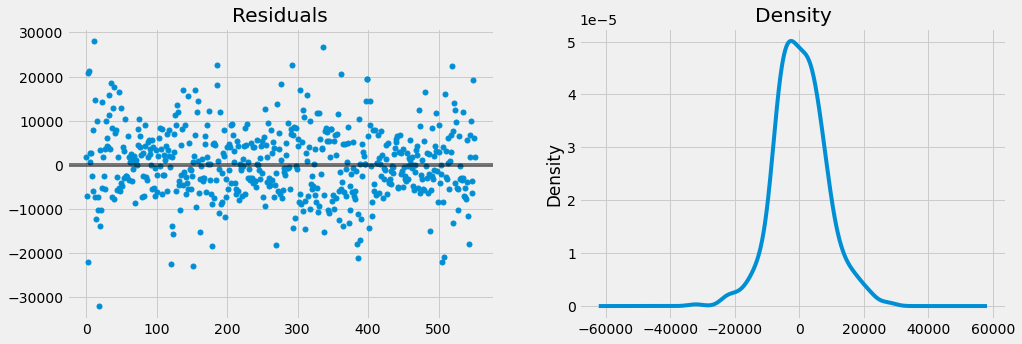

In [88]:
# Plot residuals
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2,figsize = (15,5))
residuals.plot(linestyle='',marker='.',markersize=10,title="Residuals", ax=ax[0],legend=None)
residuals.plot(kind='kde', title='Density', ax=ax[1],legend=None)
ax[0].axhline(y=0,color='black',alpha=0.5);


>The residuals are normally distributed around 0

If there is negative auto-correlation at lag 1 for ACF then it indicates over-differencing. Here autocorrelation is positive for the first lag so it is not over differenced and I can proceed with running the model.

>Forecasts for the differenced model have a better rmse so it is a better model. Next to try is use to create more features and use other machine learning models to improve predictions

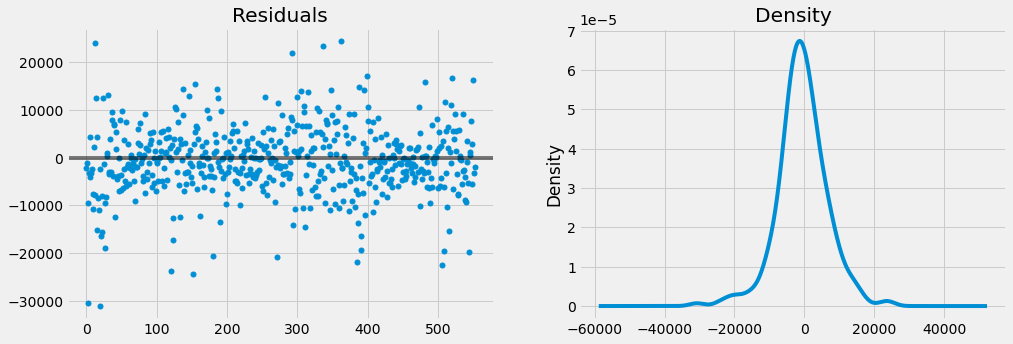

In [89]:
# Plot residuals
residuals = pd.DataFrame(model_fit_2.resid)
fig, ax = plt.subplots(1,2,figsize = (15,5))
residuals.plot(linestyle='',marker='.',markersize=10,title="Residuals", ax=ax[0],legend=None)
residuals.plot(kind='kde', title='Density', ax=ax[1],legend=None)
ax[0].axhline(y=0,color='black',alpha=0.5);

[Menu](#menu)
<a id=summary></a>
## Summary:
1. The data with the missing customer ID was added to the dataframe
2. Perform several visualizations on daily, weekly, monthly, quarterly, and yearly sales, as well as for customer count.
3. Sales variable was right skewed so I used values from 1% to 99% of the variable and then took the log of it to normalize it so models can be run on it.
4. Models tried are Linear Regression, KNearest Neighbor, and Random Forest, but their accuracy was low and residuals were not normal
5. Next try ARIMA on the daily sales
6. to test if the data is stationary I ran the dicky fuller test and the rolling mean test. Result was that the data is not stationary and needed to be differenced once
7. ACF and PACF graphs were used to get values for p and q to get a preliminary graph
8. Optimize values for p, d, and q.
